In [3]:
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

In [ ]:
##步驟
'''
1. 首先產生3個隨機中心點
2. 產生其他組隨機點
3. 隨機的點與先前產生的中心點，採用依靠最近的距離的方式分群
4. 接著更新中心點，找到群裡的中心點當作新的中心點
5. 不斷重複3 & 4
'''
##　使用到numpy 隨機、找距離、找平均、矩陣運算
## 需要將RGB影像重新塑造為MX3大小的組合(M為圖像的pixel)
## 要思考k怎麼樣最理想，看結果呈現有沒有分錯類

## 模擬版本

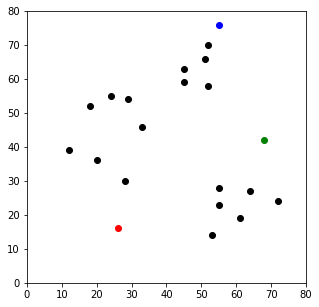

In [4]:
df=pd.DataFrame(
{
    'x':[12,20,28,18,29,33,24,45,45,52,51,52,55,53,55,61,64,72],
    'y':[39,36,30,52,54,46,55,59,63,70,66,58,23,14,28,19,27,24]
}
)
np.random.seed(200)
#有幾個k點
k=3
centroids={
    i+1:[np.random.randint(0,80),np.random.randint(0,80)]
    for i in range(k)
}
fig=plt.figure(figsize=(5,5))
plt.scatter(df['x'],df['y'],color='k')
colmap={1:'r',2:'g',3:'b'}
for i in centroids.keys():
    plt.scatter(*centroids[i],color=colmap[i])
plt.xlim(0,80)
plt.ylim(0,80)
plt.show()

    x   y  distance_from_1  distance_from_2  distance_from_3  closest color
0  12  39        26.925824        56.080300        56.727418        1     r
1  20  36        20.880613        48.373546        53.150729        1     r
2  28  30        14.142136        41.761226        53.338541        1     r
3  18  52        36.878178        50.990195        44.102154        1     r
4  29  54        38.118237        40.804412        34.058773        3     b


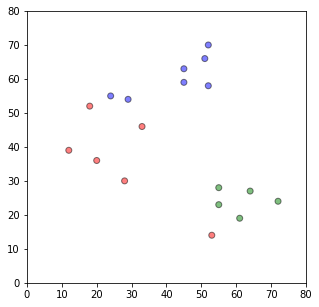

In [5]:
def assignment(df,centroids):
    for i in centroids.keys():
        df['distance_from_{}'.format(i)]=(
            np.sqrt(((df['x']-centroids[i][0])**2)+(df['y']-centroids[i][1])**2)
    )
    centroid_distance_cols=['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closest']=df.loc[:,centroid_distance_cols].idxmin(axis=1)
    df['closest']=df['closest'].map(lambda x:int(x.lstrip('distance_from_')))
    df['color']=df['closest'].map(lambda x:colmap[x])
    return df

df=assignment(df,centroids)
print(df.head())

fig=plt.figure(figsize=(5,5))
plt.scatter(df['x'],df['y'],color=df['color'],alpha=0.5,edgecolor='k')
plt.xlim(0,80)
plt.ylim(0,80)
plt.show()

{1: [27.333333333333332, 36.166666666666664], 2: [61.4, 24.2], 3: [42.57142857142857, 60.714285714285715]}
{1: [26, 16], 2: [68, 42], 3: [55, 76]}


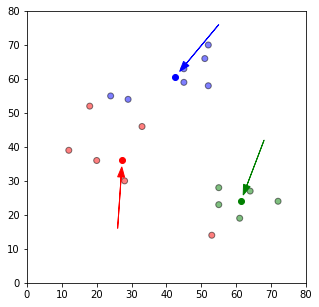

In [6]:
import copy
old_centroids=copy.deepcopy(centroids)

def update(k):
    for i in centroids.keys():
        centroids[i][0]=np.mean(df[df['closest']==i]['x'])
        centroids[i][1]=np.mean(df[df['closest']==i]['y'])
    return k
centroids=update(centroids)
print(centroids)
print(old_centroids)
fig=plt.figure(figsize=(5,5))
ax=plt.axes()
plt.scatter(df['x'],df['y'],color=df['color'],alpha=0.5,edgecolors='k')

for i in centroids.keys():
    plt.scatter(*centroids[i],color=colmap[i])
plt.xlim(0,80)
plt.ylim(0,80)
for i in old_centroids.keys():
    old_x=old_centroids[i][0]
    old_y=old_centroids[i][1]
    dx=(centroids[i][0]-old_centroids[i][0])*0.75
    dy=(centroids[i][1]-old_centroids[i][1])*0.75
    ax.arrow(old_x,old_y,dx,dy,head_width=2,head_length=3,fc=colmap[i],ec=colmap[i])
plt.show()

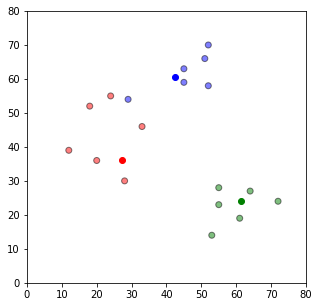

In [7]:
df=assignment(df,centroids)

fig=plt.figure(figsize=(5,5))
plt.scatter(df['x'],df['y'],color=df['color'],alpha=0.5,edgecolors='k')
for i in centroids.keys():
    plt.scatter(*centroids[i],color=colmap[i])
plt.xlim(0,80)
plt.ylim(0,80)
plt.show()

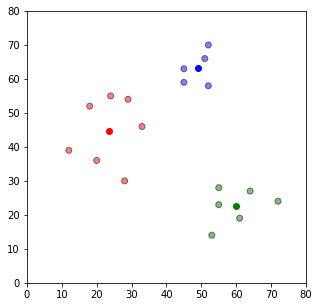

In [8]:
while True:
    closest_centroids=df['closest'].copy(deep=True)
    centroids=update(centroids)
    df=assignment(df,centroids)
    if closest_centroids.equals(df['closest']):
        break
fig=plt.figure(figsize=(5,5))
plt.scatter(df['x'],df['y'],color=df['color'],alpha=0.5,edgecolors='k')
for i in centroids.keys():
    plt.scatter(*centroids[i],color=colmap[i])
plt.xlim(0,80)
plt.ylim(0,80)
plt.show()

### 實際版本(要改良)

In [11]:
#kmean中心點設定為3
K = 3
#執行3次後收斂
N = 3
input_filepath = 'D:\\ncku.jpg'
img = Image.open(input_filepath)
data = np.array(img) / 255.0 # HWC

# 原本是隨便挑顏色(舊)
center = np.random.uniform(low=0, high=1.0, size=(K, data.shape[2]))
cluster = np.ndarray(data.shape[0:2], dtype=np.int32)
#定義影像上的某一點跟seed中心點計算距離
def distance(x: np.ndarray, y: np.ndarray) -> np.float32:
    return np.dot(x - y, x - y) ** (1 / 2)

In [12]:
for round in range(N):
    print('Round = ' + str(round))
    # find the nearest center
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            min_distance = float('inf')
            min_cluster = None
            for c in range(K):
                #算跟每個seed的距離
                d = distance(data[i,j], center[c])
                # 找到一個點跟每個seed最短的
                if d < min_distance:
                    min_cluster = c
                    min_distance = d
            cluster[i,j] = min_cluster
    #當分完類別
    # calculate the average point
    for c in range(K):
        count = 0
        total = np.ndarray(data.shape[2])
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if cluster[i,j] == c:
                    count += 1
                    total += data[i,j]
        if count > 0:
            center[c] = total / count

Round = 0
Round = 1
Round = 2


In [13]:
cluster_map = np.ndarray(data.shape)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        cluster_map[i,j] = center[cluster[i,j]]


In [14]:
np.clip(cluster_map, 0, 1)
cluster_map *= 255
cluster_img = Image.fromarray(cluster_map.astype(np.uint8)) # Convert to PIL format
#將array轉成圖片
# result_img=Image.fromarray(cluster_img.astype(np.uint8),'L')

output_filepath = 'D:\\output.jpg'
print('Save image to ' + output_filepath)
cluster_img.save(output_filepath)

Save image to D:\output.jpg


## 改良版本

In [15]:
#kmean中心點設定為3
K = 3
#執行3次後收斂
N = 3
input_filepath = 'D:\\ncku.jpg'
img = Image.open(input_filepath)
data = (np.array(img) / 255.0).shape # HWC
hight=data[0]

#改良新增的，選取範圍點要是影像中的顏色
#將3維reshap
arr=data.reshape(data.shape[0] * data.shape[1],data.shape[2])
#改良新的，改成從影像的dataset裡面挑顏色
center=arr[np.random.choice(arr.shape[0],size=k,replace=False)]

cluster = np.ndarray(data.shape[0:2], dtype=np.int32)
#定義影像上的某一點跟seed中心點計算距離
def distance(x: np.ndarray, y: np.ndarray) -> np.float32:
    return np.dot(x - y, x - y) ** (1 / 2)

In [16]:
for round in range(N):
    print('Round = ' + str(round))
    # find the nearest center
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            min_distance = float('inf')
            min_cluster = None
            for c in range(K):
                #算跟每個seed的距離
                d = distance(data[i,j], center[c])
                # 找到一個點跟每個seed最短的
                if d < min_distance:
                    min_cluster = c
                    min_distance = d
            cluster[i,j] = min_cluster
    #當分完類別
    # calculate the average point
    for c in range(K):
        count = 0
        total = np.ndarray(data.shape[2])
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if cluster[i,j] == c:
                    count += 1
                    total += data[i,j]
        if count > 0:
            center[c] = total / count



Round = 0
Round = 1
Round = 2


In [17]:
cluster_map = np.ndarray(data.shape)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        cluster_map[i,j] = center[cluster[i,j]]

np.clip(cluster_map, 0, 1)
cluster_map *= 255
cluster_img = Image.fromarray(cluster_map.astype(np.uint8)) # Convert to PIL format
#將array轉成圖片
# result_img=Image.fromarray(cluster_img.astype(np.uint8),'L')

output_filepath = 'D:\\output.jpg'
print('Save image to ' + output_filepath)
cluster_img.save(output_filepath)

Save image to D:\output.jpg


### 直接call function

(1333, 2000, 3)


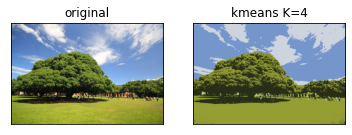

In [11]:
# coding: utf-8
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取原始影像
img = cv2.imread('D:\\ncku.jpg')
print(img.shape)

# 影像二維畫素轉換為一維
data = img.reshape((-1, 3))
data = np.float32(data)

# 定義中心 (type,max_iter,epsilon)
criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# 設定標籤
flags = cv2.KMEANS_RANDOM_CENTERS



# K-Means聚類 聚整合4類
compactness, labels4, centers4 = cv2.kmeans(data, 4, None, criteria, 10, flags)

# 影像轉換回uint8二維型別

centers4 = np.uint8(centers4)
res = centers4[labels4.flatten()]
dst4 = res.reshape((img.shape))



# 影像轉換為RGB顯示
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst4 = cv2.cvtColor(dst4, cv2.COLOR_BGR2RGB)

#array轉image
result_img=Image.fromarray(dst4)
result_img.save('D:\\output.jpg')

result=cv2.imread('D:\\output.jpg')
result_resize= cv2.resize(result, (600, 400), interpolation=cv2.INTER_NEAREST)
cv2.imshow('result_image',result_resize)
cv2.waitKey(0)
cv2.destroyAllWindows()

# ##存檔
# ## PIL轉openCV
# result_img = cv2.cvtColor(np.asarray(dst4),cv2.COLOR_RGB2BGR)  
# output_filepath = 'D:\\output.jpg'
# print('Save image to ' + output_filepath)
# result_img.save(output_filepath)

# 顯示影像
titles = ['original', 'kmeans K=4',]
images = [img,dst4]
for i in range(2):
    plt.subplot(1, 2, i + 1), plt.imshow(images[i], 'gray'),
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()